In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
gids = [28930, 28015, 29465, 29325, 29517, 29463, 29527, 30064, 28121]
radii_f125 = [10.44, 22.09, 13.13, 9.52, 5.58, 6.04, 3.20, 1.74, 0.64]
radii_f160 = [8.49, 15.99, 10.96, 5.97, 3.87, 5.33, 2.54, 2.66, 1.33]
axis_ratio = [0.76, 0.93, 0.18, 0.93, 0.59, 0.59, 0.89, 0.61, 0.70] # for f160

In [3]:
def r_circ(r_eff):
    r_circ = r_eff*np.sqrt(axis_ratio)
    return r_circ

In [4]:
for i in range(len(gids)):
    r125 = r_circ(radii_f125[i])
    r160 = r_circ(radii_f160[i])
    
print(r125)
print(r160)

[ 0.55793906  0.61719365  0.271529    0.61719365  0.49159333  0.49159333
  0.60377479  0.49985598  0.53546242]
[ 1.15946712  1.28260555  0.56427121  1.28260555  1.02159238  1.02159238
  1.25471949  1.03876321  1.11275784]


In [5]:
delta_Reff = r125-r160
print(delta_Reff)

[-0.60152805 -0.6654119  -0.29274221 -0.6654119  -0.52999906 -0.52999906
 -0.6509447  -0.53890723 -0.57729542]


In [13]:
df = pd.DataFrame(list(zip(gids, r125, r160, delta_Reff)), 
               columns =['Objects', 'F125W Circ $R_{eff}$', 'F160W Circ $R_{eff}$', '$\Delta R_{eff}$ ($R_{F125W}-R_{F160W}$)']) 

df

,Objects,F125W Circ $R_{eff}$,F160W Circ $R_{eff}$,$\Delta R_{eff}$ ($R_{F125W}-R_{F160W}$)
0,28930,0.557939,1.159467,-0.601528
1,28015,0.617194,1.282606,-0.665412
2,29465,0.271529,0.564271,-0.292742
3,29325,0.617194,1.282606,-0.665412
4,29517,0.491593,1.021592,-0.529999
5,29463,0.491593,1.021592,-0.529999
6,29527,0.603775,1.254719,-0.650945
7,30064,0.499856,1.038763,-0.538907
8,28121,0.535462,1.112758,-0.577295


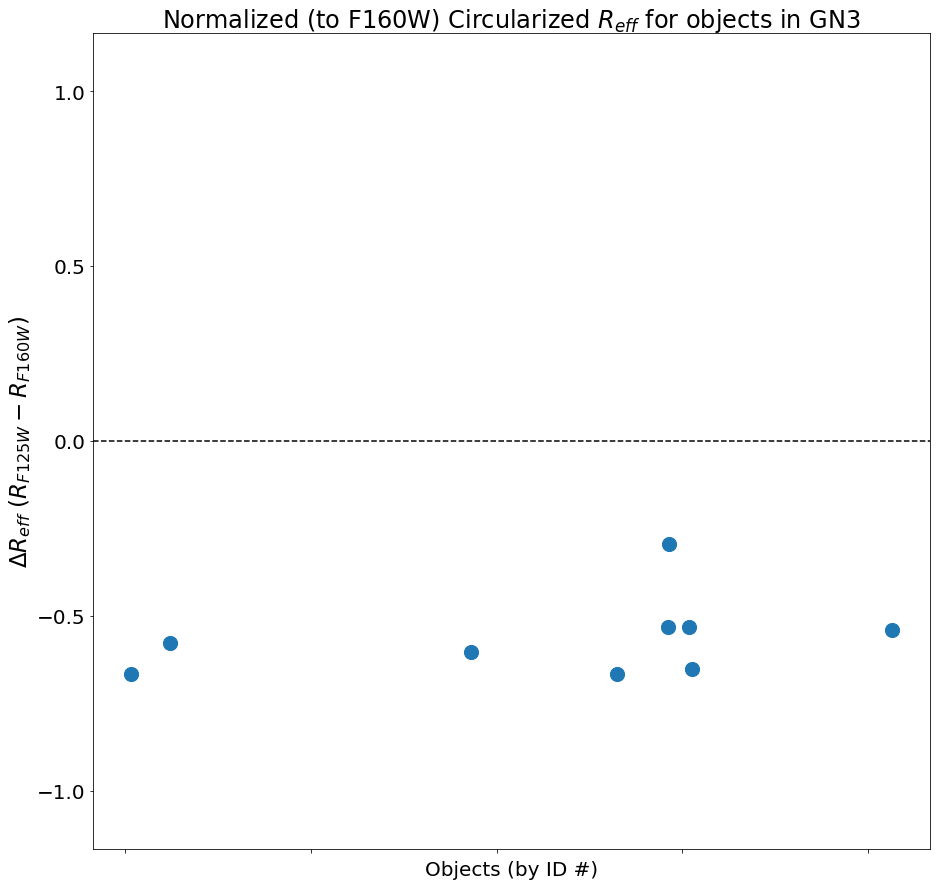

In [6]:
plt.rcParams.update({'font.size': 20})

fig,ax = plt.subplots(1, figsize=(15,15))

ax.scatter(gids, delta_Reff, s=200)

ax.set_xlabel('Objects (by ID #)')
ax.set_ylabel('$\Delta R_{eff}$ ($R_{F125W}-R_{F160W}$)', size=23)
ax.set_ylim(bottom = min(delta_Reff)-0.5, top = abs(min(delta_Reff))+0.5,)
ax.axhline(y=0, linestyle='--', color='black')
ax.set_xticklabels([])
ax.set_title('Normalized (to F160W) Circularized $R_{eff}$ for objects in GN3')
plt.savefig('circ_R_eff_F125W.png')
plt.show()

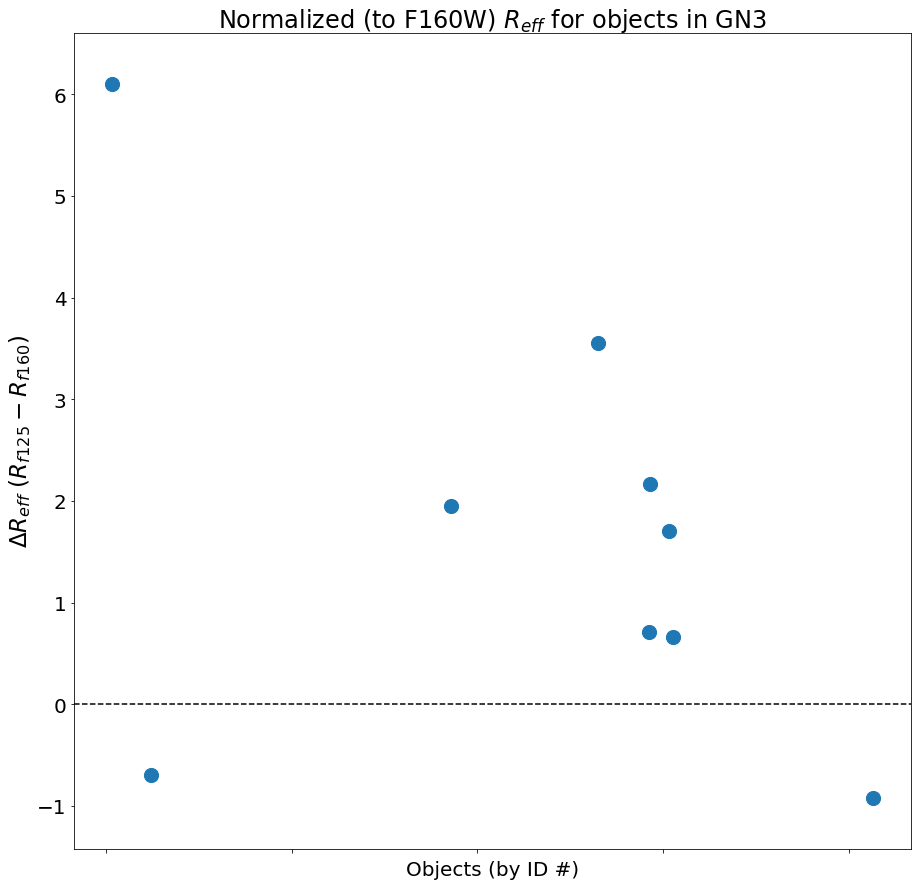

In [7]:
fig,ax = plt.subplots(1, figsize=(15,15))

data = np.array(radii_f125)-np.array(radii_f160)

ax.scatter(gids, data, s=200)

ax.set_xlabel('Objects (by ID #)')
ax.set_ylabel('$\Delta R_{eff}$ ($R_{f125}-R_{f160}$)', size=23)
ax.set_ylim(bottom = min(data)-0.5, top = max(data)+0.5,)
ax.axhline(y=0, linestyle='--', color='black')
ax.set_xticklabels([])
ax.set_title('Normalized (to F160W) $R_{eff}$ for objects in GN3')
plt.savefig('R_eff_F125W.png')
plt.show()